In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from pathlib import Path

path = str(Path().resolve())
print(path)
path = path + "\\ADNI_PROCESSED"

# For kaggle:
path = "../input/adni-data/ADNI_PROCESSED"

def apply_mask(img_n_mmni, img_mask):
    """
        Taking a n_mmni and apply the correspondant mask
        param:
            img_n_mmi   : image n_mmi
            img_mask    : mask
    """
    mmni_m = img_n_mmni.get_fdata()
    mask_m = img_mask.get_fdata().astype(bool)
    mask_bg = np.logical_not(mask_m)
    mmni_m[mask_bg] = 0
    return mmni_m

def process_irm_data():
    """
        Create a new directory and process all images from tha ADNI1 directory
    """
    path = str(Path().resolve())
    path_res = path + "\\ADNI_PROCESSED"
    Path(path_res).mkdir(parents=True, exist_ok=True) # Create a directory for data processed
    path = path + "\\ADNI1"
    for filename in os.listdir(path):
        if filename.startswith("n_mmni"):
            n_mmni_filename = os.path.join(path, filename)
            mask_filename = os.path.join(path, "mask_" + filename)
            img_n_mmni = nib.load(n_mmni_filename)
            img_mask = nib.load(mask_filename)
            n_mmni_mask = apply_mask(img_n_mmni, img_mask)
            img = nib.Nifti1Image(n_mmni_mask, np.eye(4))
            nib.save(img, os.path.join(path_res, filename))

/kaggle/working


In [2]:
def cut_2D_i(img_n_mmni, axe, idx):
    """
        Function that returns a 2D cut from the "img" in the index "idx", along the axe given in parameter
    """
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim[axe] <= idx or idx < 0:
        print("Invalid value for index must be between 0 and " , axe_dim[axe])
        return
    if axe == "x":
        cropped_img = img_n_mmni.slicer[idx:idx+1, 90:130, 40:80]
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (2, 1, 0)) / 255.0
        img_data = np.transpose(img_data, (1, 0, 2))
    elif axe == "y":
        cropped_img = img_n_mmni.slicer[100:140, idx:idx+1,40:80]
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (0, 2, 1)) / 255.0
    elif axe == "z":
        cropped_img = img_n_mmni.slicer[100:140, 90:130, idx:idx+1]
        img_data = cropped_img.get_fdata()
    else:
        print("Choose a valid value for axe: x, y or z")

    return img_data

def custom_patch_3D(img_n_mmni, x_tup, y_tup, z_tup):
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim["x"] <= x_tup[1] or x_tup[0] < 0 or axe_dim["y"] <= y_tup[1] or y_tup[0] < 0 or axe_dim["z"] <= z_tup[1] or z_tup[0] < 0 :
        print("Invalid values")
        return 
    else:
        cropped_img = img_n_mmni.slicer[x_tup[0]:x_tup[1], y_tup[0]:y_tup[1], z_tup[0]:z_tup[1]]
        img_data = cropped_img.get_fdata() / 255
        return img_data

In [3]:
import os
import re
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

def load_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[(data.Group == 'CN') | (data.Group == 'AD')]
    return data

path = str(Path().resolve())
path = "../input/adni-data/list_standardized_tongtong_2017.csv"
y_data = load_data(path)
y_data.head(7)

,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [4]:
from tensorflow.keras.utils import to_categorical

usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    X_data_index = []
    X_hypo = [] # 0 for left, 1 for right
    Y_test = []
    path = "../input/adni-data/ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                img_on_three_axes = []
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(59,62), y_tup=(90,130), z_tup=(40,80))
                img_data = np.transpose(img_data, (1, 2, 0))
                img_on_three_axes.append(img_data)
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(40,80), y_tup=(109,112), z_tup=(40,80))
                img_data = np.transpose(img_data, (0, 2, 1))
                img_on_three_axes.append(img_data)
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(40,80), y_tup=(90,130), z_tup=(59,62))
                img_on_three_axes.append(img_data)
                
                img_on_three_axes = np.array(img_on_three_axes)
                X_data.append(img_on_three_axes)
                X_data_index.append(index)
                X_hypo.append(1)
                
                img_on_three_axes = []
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(119,122), y_tup=(90,130), z_tup=(40,80))
                img_data = img_data[::-1,:,:]
                img_data = np.transpose(img_data, (1, 2, 0))
                img_on_three_axes.append(img_data)
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(100,140), y_tup=(109,112), z_tup=(40,80))
                img_data = np.transpose(img_data, (0, 2, 1))
                img_data = img_data[::-1,:,:]
                img_on_three_axes.append(img_data)
                
                img_data = custom_patch_3D(img_n_mmni, x_tup=(100,140), y_tup=(90,130), z_tup=(59,62))
                img_data = img_data[::-1,:,:]
                img_on_three_axes.append(img_data)
                
                img_on_three_axes = np.array(img_on_three_axes)
                X_data.append(img_on_three_axes)
                X_data_index.append(index)
                X_hypo.append(0)
                
                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
                    Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index, X_data_index, X_hypo

#if os.path.isfile('X_data.npy') and os.path.isfile('Y_data.npy') and os.path.isfile('X_test_index.npy'):
#    X_data = np.load('X_data.npy')
#    Y_data = np.load('Y_data.npy')
#    X_test_index = np.load('X_test_index.npy')
#else:
X_data, Y_data_list, X_test_index, X_data_index, X_hypo = prepare_X_of_Y(y_data)
Y_data = to_categorical(Y_data_list, num_classes=2)
#np.save('X_data', X_data)
#np.save('Y_data', Y_data)
#np.save('X_test_index', X_test_index)

print(len(X_data) == len(Y_data))
print(len(X_data))

True
830


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test, X_train_index, X_test_index, X_hypo_train, X_hypo_test = train_test_split(X_data, Y_data, X_data_index, X_hypo, random_state=42, test_size=0.2)
#X_train, X_val, Y_train, Y_val, X_train_index, X_val_index = train_test_split(X_train, Y_train, X_train_index, random_state=42, test_size=0.2)

print("Data splited")
print(len(X_train))

Data splited
664


{0: 'CN', 1: 'AD'}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


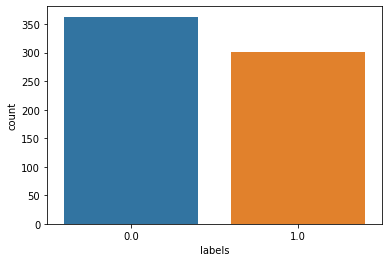

In [6]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"] = Y_train[:,1]
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [7]:
def data_augmentation(X_train, Y_train, X_train_index, X_hypo):
    new_X = []
    new_Y = []
    path = "../input/adni-data/ADNI_PROCESSED"
    for j in range(len(X_train_index)):
        file = path + '/n_mmni_fADNI_' + X_train_index[j] + '_1.5T_t1w.nii'
        new_X.append(X_train[j])
        new_Y.append(Y_train[j])
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            if X_hypo[j]:
                x = (100,140); x_slice = (119,122)
            else:
                x = (40,80); x_slice = (59,62)
            for i in range(-3, 4):
                if i != 0:
                    img_on_three_axes = []
                    
                    img_data = custom_patch_3D(img_n_mmni, x_tup=(x_slice[0]+i,x_slice[1]+i), y_tup=(90+i,130+i), z_tup=(40+i,80+i))
                    img_data = img_data[::-1,:,:]
                    img_data = np.transpose(img_data, (1, 2, 0))
                    img_on_three_axes.append(img_data)

                    img_data = custom_patch_3D(img_n_mmni, x_tup=(x[0]+i, x[1]+i), y_tup=(109+i,112+i), z_tup=(40+i,80+i))
                    img_data = np.transpose(img_data, (0, 2, 1))
                    img_data = img_data[::-1,:,:]
                    img_on_three_axes.append(img_data)

                    img_data = custom_patch_3D(img_n_mmni, x_tup=(x[0]+i, x[1]+i), y_tup=(90+i,130+i), z_tup=(59+i,62+i))
                    img_on_three_axes.append(img_data)
                    img_data = img_data[::-1,:,:]
                    img_on_three_axes = np.array(img_on_three_axes)
                        
                    new_X.append(img_on_three_axes)
                    new_Y.append(Y_train[j])
                        
    return np.array(new_X), np.array(new_Y)
X_train, Y_train = data_augmentation(X_train, Y_train, X_train_index, X_hypo_train)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.2)

print("Data splited")
print(len(X_train))

Data splited
3718


{0: 'CN', 1: 'AD'}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


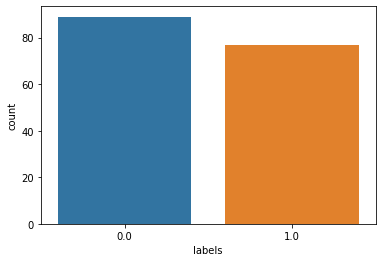

In [9]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"] = Y_test[:,1]
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [10]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def intermediate_network(inputs, i, depth, padding='same'):
    x = inputs[:,i,:,:]
    
    num_filters = 32
    for i in range(depth):
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(intermediate_network(inputs=inputs, i=i, depth=4, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    x = Dense(512, activation='relu', name = "Dense1")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

In [11]:
from tensorflow.keras.optimizers import Adam

model_2 = create_model_2D_epsilon(X_train[0].shape)
model_2.summary()
model_2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

2021-12-12 22:28:24.389261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 22:28:24.542034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 22:28:24.542969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 22:28:24.544571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 40, 40, 3 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 40, 40, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 40, 40, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 40, 40, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

In [12]:
history = model_2.fit(X_train, Y_train, epochs=80, validation_data=(X_val, Y_val))

2021-12-12 22:28:27.791397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2021-12-12 22:28:32.444117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 16s 54ms/step - loss: 0.7850 - accuracy: 0.6477 - val_loss: 0.7000 - val_accuracy: 0.5634
Epoch 2/80
117/117 [==============================] - 6s 48ms/step - loss: 0.6523 - accuracy: 0.7195 - val_loss: 0.7348 - val_accuracy: 0.5634
Epoch 3/80
117/117 [==============================] - 6s 49ms/step - loss: 0.5961 - accuracy: 0.7466 - val_loss: 0.7791 - val_accuracy: 0.5634
Epoch 4/80
117/117 [==============================] - 6s 50ms/step - loss: 0.5600 - accuracy: 0.7730 - val_loss: 0.8865 - val_accuracy: 0.5634
Epoch 5/80
117/117 [==============================] - 6s 49ms/step - loss: 0.5076 - accuracy: 0.7956 - val_loss: 0.9119 - val_accuracy: 0.5634
Epoch 6/80
117/117 [==============================] - 6s 48ms/step - loss: 0.4667 - accuracy: 0.8077 - val_loss: 0.6684 - val_accuracy: 0.6376
Epoch 7/80
117/117 [==============================] - 6s 48ms/step - loss: 0.4283 - accuracy: 0.8308 - val_loss: 0.5383 - val_accuracy: 0.7602
Epoch 8/8

## Loss visualization function
This function is used to visualize the variations of loss, val_loss, accuracy and val_accuracy over epochs. It is used for 3D and 2D models. 

In [13]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
      """
      Returns separate loss curves for training and validation metrics.
      """ 
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()
      plt.savefig('accuracy.png')

In [14]:
#Evaluating the model on testing data

test_scores = model_2.evaluate(X_test, Y_test)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

6/6 [==============================] - 0s 8ms/step - loss: 0.9720 - accuracy: 0.8193
Testing Accuracy: 81.93%


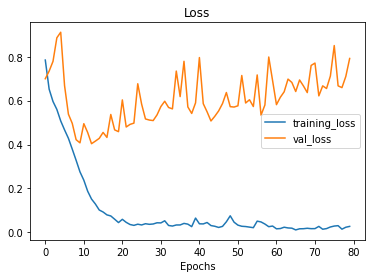

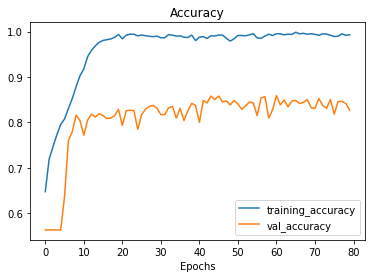

In [15]:
plot_loss_curves(history)

[1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0
 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1
 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0
 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1]
[[77 12]
 [18 59]]


<AxesSubplot:>

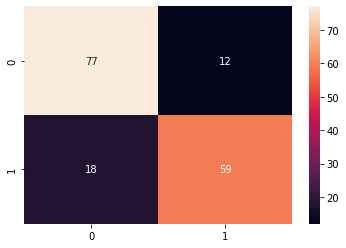

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
prediction_unet = model_2.predict(X_test)
prediction_unet = np.argmax(prediction_unet, axis=-1)
Y_labels = np.argmax(Y_test, axis=-1)
print(Y_labels)
cm = confusion_matrix(Y_labels, prediction_unet)
print(cm)
sns.heatmap(cm, annot=True)

# Prediction and vizualisation on MCI

In [17]:
from tensorflow.keras.utils import to_categorical

def prepare_data_viz():
    path = "../input/adni-data/list_standardized_tongtong_2017.csv"
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group', 'Conversion'])
    data.index = data['Subject ID']
    Y = data.drop(['Subject ID'], axis=1)
    X_data = []
    Y_data = []
    path_img = "../input/adni-data/ADNI_PROCESSED"
    for index, row in Y.iterrows():
        file = path_img + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            img_on_three_axes = []

            img_data = custom_patch_3D(img_n_mmni, x_tup=(59,62), y_tup=(90,130), z_tup=(40,80))
            img_data = np.transpose(img_data, (1, 2, 0))
            img_on_three_axes.append(img_data)

            img_data = custom_patch_3D(img_n_mmni, x_tup=(40,80), y_tup=(109,112), z_tup=(40,80))
            img_data = np.transpose(img_data, (0, 2, 1))
            img_on_three_axes.append(img_data)

            img_data = custom_patch_3D(img_n_mmni, x_tup=(40,80), y_tup=(90,130), z_tup=(59,62))
            img_on_three_axes.append(img_data)

            img_on_three_axes = np.array(img_on_three_axes)
            X_data.append(img_on_three_axes)

            if Y['Group'][index] == "AD":
                Y_data.append(3)
            elif Y['Group'][index] == "CN":
                Y_data.append(0)
            elif Y['Group'][index] == "MCI":
                if Y['Conversion'][index] == 4:
                    Y_data.append(1)
                else:
                    Y_data.append(2)
    return np.array(X_data), Y_data

X_viz, Y_viz = prepare_data_viz()

In [18]:
features_flatten = Model(
    inputs=model_2.inputs,
    outputs=model_2.get_layer(name="Dense1").output,
)

X_layer_pred = features_flatten.predict(X_viz)
print(X_layer_pred.shape)

(817, 512)


# PCA

In [19]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(X_layer_pred)
print("shape of pca_reduced.shape", pca_data.shape)

shape of pca_reduced.shape (817, 2)


In [20]:
import seaborn as sn
pca_data = np.vstack((pca_data.T, Y_viz)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pca-one", "pca-two", "Group"))
pca_df_AD_CN = pca_df[(pca_df.Group == 0) | (pca_df.Group == 3)]

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

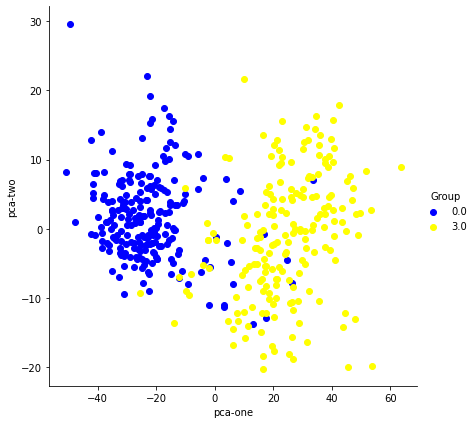

In [21]:
sn.FacetGrid(pca_df_AD_CN, hue="Group", size=6, palette=["blue", "yellow"]).map(plt.scatter, "pca-one", "pca-two").add_legend()
plt.show

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

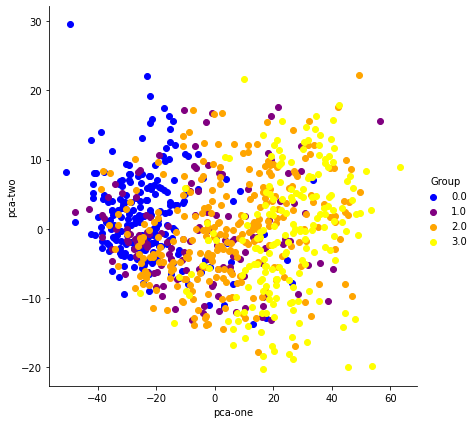

In [23]:
colors = ["blue", "purple", "orange", "yellow"]
sn.FacetGrid(pca_df, hue="Group", size=6, palette=colors).map(plt.scatter, "pca-one", "pca-two").add_legend()
plt.show

In [24]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
pca.fit(X_layer_pred)
pca_data = pca.transform(X_layer_pred)

pca_data = np.vstack((pca_data.T, Y_viz)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pca-one", "pca-two", "Group"))
pca_df_AD_CN = pca_df[(pca_df.Group == 0) | (pca_df.Group == 3)]

In [27]:
fig = px.scatter_matrix(
    pd.DataFrame(data=pca_df_AD_CN, columns=("pca-one", "pca-two")).to_numpy(),
    dimensions=range(2),
    color=pca_df_AD_CN["Group"].to_numpy(),
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [28]:
fig = px.scatter_matrix(
    pd.DataFrame(data=pca_df, columns=("pca-one", "pca-two")).to_numpy(),
    dimensions=range(2),
    color=pca_df["Group"].to_numpy(),
)
fig.update_traces(diagonal_visible=False)
fig.show()

# TSNE

In [30]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=800)
tsne_results = tsne.fit_transform(X_layer_pred)
tsne_data = np.vstack((tsne_results.T, Y_viz)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("tsne-2d-one", "tsne-2d-two", "Group"))
tsne_df_AD_CN = tsne_df[(tsne_df.Group == 0) | (tsne_df.Group == 3)]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 817 samples in 0.074s...
[t-SNE] Computed neighbors for 817 samples in 0.678s...
[t-SNE] Computed conditional probabilities for sample 817 / 817
[t-SNE] Mean sigma: 5.848882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.607964
[t-SNE] KL divergence after 800 iterations: 0.956452


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



<Figure size 1152x720 with 0 Axes>

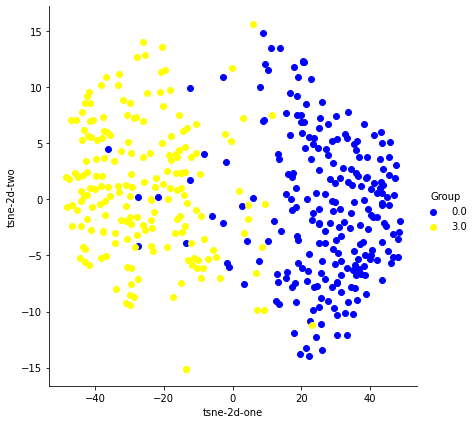

In [31]:
plt.figure(figsize=(16,10))

sn.FacetGrid(tsne_df_AD_CN, hue="Group", size=6, palette=["blue", "yellow"]).map(plt.scatter, "tsne-2d-one", "tsne-2d-two").add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



<Figure size 1152x720 with 0 Axes>

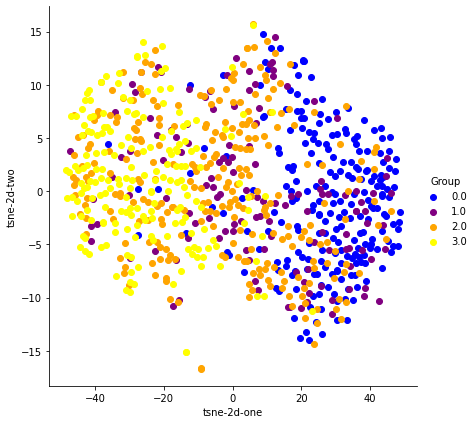

In [32]:
plt.figure(figsize=(16,10))

sn.FacetGrid(tsne_df, hue="Group", size=6, palette=colors).map(plt.scatter, "tsne-2d-one", "tsne-2d-two").add_legend()

In [33]:
fig = px.scatter_matrix(
    pd.DataFrame(data=tsne_df_AD_CN, columns=("tsne-2d-one", "tsne-2d-two")).to_numpy(),
    dimensions=range(2),
    color=tsne_df_AD_CN["Group"].to_numpy()
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [34]:
fig = px.scatter_matrix(
    pd.DataFrame(data=tsne_df, columns=("tsne-2d-one", "tsne-2d-two")).to_numpy(),
    dimensions=range(2),
    color=tsne_df["Group"].to_numpy()
)
fig.update_traces(diagonal_visible=False)
fig.show()